In [1]:
%matplotlib inline  

import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sys, glob
import math
from scipy import interpolate
from astropy.io import fits
from decimal import Decimal
from datetime import date


In [2]:
def func0(ff,f0, df, qi, qc):
    qt=qi*qc/(qi+qc)
    tf0= f0 + df
    x=(ff- tf0)/tf0
    S21=(1/qi+2*1j*(x+df/f0))/(1/qt+2*1j*x)
    return np.abs(S21)

In [6]:
data_dir = '/home/tangq/S21_analysis/20190523_Dark_Data_Manual/VNA_Sweeps/'
save_dir = data_dir + "Fits/"
nres = 18
Tset = ['0030', '0130', '0230', '0330','0430','0630','0830','1030']
Pset = ['4.0','0.0','-4.0','-8.0']
f0set = np.zeros((len(Tset), len(Pset), nres))
dfset = np.zeros((len(Tset), len(Pset), nres))
Qiset = np.zeros((len(Tset), len(Pset), nres))
Qcset = np.zeros((len(Tset), len(Pset), nres))
file_ext = '.png'

for t in range(len(Tset)):
    for p in range(len(Pset)):
        file = data_dir + "S21_Segmented_BTEMP" + Tset[t]+"_mK_POW"+Pset[p]+"_dB_ATT10.0_dB.fits"
        hdulist = fits.open(file)
        totalfreq = hdulist[1].data['Freq']
        reS21 = hdulist[1].data['ReS21']
        imS21 = hdulist[1].data['ImS21']
        totalabsS21 = np.abs(reS21 + 1.j*imS21)
        npoints = int(len(totalfreq)/nres)
        for r in range(nres):
            freq = totalfreq[r*npoints:(r+1)*npoints]
            absS21 = totalabsS21[r*npoints:(r+1)*npoints]
            #plt.plot(freq, absS21,'.')
            diffS21 = abs(np.diff(absS21))
            indices = np.where(diffS21 > 2*np.std(diffS21))[0]
            cont_ind = np.where(np.diff(indices)==1)[0]
            a = np.diff(indices)
            b = np.ones(4,dtype = int)
            indexes = []
            for i in range(len(a)-len(b)+1):
                if (a[i:i+len(b)] == b).all():
                    indexes.append(i)
            indices = indices[indexes[0]:indexes[-1]+len(b)]
            start_ind = int(indices[0] - 2*(indices[-1]-indices[0]))
            end_ind = int(indices[-1] + 2*(indices[-1]-indices[0]))
            if start_ind < 0:
                start_ind = 0
            if end_ind > (len(freq) -1 ):
                end_ind = (len(freq) -1)
            close_freq = freq[start_ind:end_ind]
            close_S21 = absS21[start_ind:end_ind]/(absS21[0])
            f0_ind = np.where(diffS21 == max(diffS21))[0]
            centrefreq = freq[f0_ind]
            Qest = 2*centrefreq/(freq[indices[-1]]- freq[indices[0]])
            if len(close_freq) < 50:
                close_freq = freq[max(0, f0_ind-30):min(f0_ind+30, len(freq)-1)]
                close_S21 = absS21[max(0, f0_ind-30):min(f0_ind+30, len(freq)-1)]/(absS21[0])
            plt.figure()
            plt.plot(close_freq,close_S21,'.',label='Data')
            popt, pcov = curve_fit(func0, close_freq, close_S21, bounds=([close_freq[0], -1.e5, 1.e4, 1.e4], [close_freq[-1], 1.e5, 1.e7, 1.e7]), p0 = [centrefreq, 0, Qest, Qest])
            plt.plot(close_freq, func0(close_freq, popt[0], popt[1], popt[2], popt[3]),linewidth = 3, label='Fits \n f0=' + "{:.3E}".format(Decimal(popt[0])) + '\n df='+"{:.3E}".format(Decimal(popt[1]))+'\n Qi='+ "{:.3E}".format(Decimal(popt[2]))+'\n Qc='+"{:.3E}".format(Decimal(popt[3])))
            plt.legend(loc = 'best', fontsize= 'x-small')
            plt.xlabel('Freq (Hz)')
            plt.ylabel('Normalized S21')
            plt.title('S21 plot at ' + Tset[t] +'mK and power of' + Pset[p]+ 'dB, res ' + str(r))
            plt.savefig(save_dir + 'Res'+str(r)+'_Temp'+ Tset[t] +'mK_Power'+Pset[p]+'dB'+file_ext)
            plt.close()
            f0set[t,p,r] = popt[0]
            dfset[t,p,r] = popt[1]
            Qiset[t,p,r] = popt[2]
            Qcset[t,p,r] = popt[3]

today = str(date.today())
np.save(save_dir+today +'f0set.npy', f0set)
np.save(save_dir+today +'dfset.npy', dfset)
np.save(save_dir+today +'Qiset.npy', Qiset)
np.save(save_dir+today +'Qcset.npy', Qcset)
file = open(save_dir+today +'files_explanation.txt',"w") 
file.write("First dimension corresponds to temperatures of ".join(Tset))
file.write("Second dimension corresponds to powers of ".join(Pset))
file.write ("Third dimension corresponds to resonators, with a total of " + str(nres) + "resonators")
file.close()

/home/tangq/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:47: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/tangq/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:48: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


False
[1 1 1 2 1 1 1 2 1 1 1 1]
[804 805 806 807]


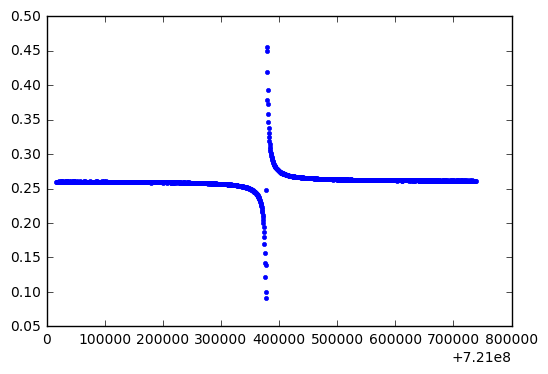

In [147]:
t = 5
p = 1
r = 3
file = data_dir + "S21_Segmented_BTEMP" + Tset[t]+"_mK_POW"+Pset[p]+"_dB_ATT10.0_dB.fits"
hdulist = fits.open(file)
totalfreq = hdulist[1].data['Freq']
reS21 = hdulist[1].data['ReS21']
imS21 = hdulist[1].data['ImS21']
totalabsS21 = np.abs(reS21 + 1.j*imS21)
npoints = int(len(totalfreq)/nres)

freq = totalfreq[r*npoints:(r+1)*npoints]
absS21 = totalabsS21[r*npoints:(r+1)*npoints]
#plt.plot(freq, absS21,'.')
diffS21 = abs(np.diff(absS21))
indices = np.where(diffS21 > 2*np.std(diffS21))[0]
cont_ind = np.where(np.diff(indices)==1)[0]
seq = np.ones(4,dtype = int)

a = np.diff(indices)
b = np.ones(4,dtype = int)
indexes = []
i = 0 
print (a[i:i+len(b)] == b).all()
for i in range(len(a)-len(b)+1):
    if (a[i:i+len(b)] == b).all():
        indexes.append(i)
print a
indices = indices[indexes[0]:indexes[-1]+len(b)]

print indices
# indices = indices[cont_ind[res_ind]]
# print indices

# start_ind = int(indices[0] - 2*(indices[-1]-indices[0]))
# end_ind = int(indices[-1] + 2*(indices[-1]-indices[0]))
# if start_ind < 0:
#     start_ind = 0
# if end_ind > (len(freq) -1 ):
#     end_ind = (len(freq) -1)
# close_freq = freq[start_ind:end_ind]
# close_S21 = absS21[start_ind:end_ind]/(absS21[0])
# f0_ind = np.where(diffS21 == max(diffS21))[0]
# centrefreq = freq[f0_ind]
# Qest = 2*centrefreq/(freq[indices[-1]]- freq[indices[0]])
# if len(close_freq) < 50:
#     close_freq = freq[max(0, f0_ind-30):min(f0_ind+30, len(freq)-1)]
#     close_S21 = absS21[max(0, f0_ind-30):min(f0_ind+30, len(freq)-1)]/(absS21[0])
# print centrefreq, Qest
# plt.figure()
#plt.plot(close_freq,close_S21,'.',label='Data')
plt.clf()
plt.plot(freq, absS21,'.')

# popt, pcov = curve_fit(func0, close_freq, close_S21, bounds=([close_freq[0], -1.e4, 1.e4, 1.e4], [close_freq[-1], 1.e4, 1.e7, 1.e7]), p0 = [centrefreq, 0, Qest, Qest])
# plt.plot(close_freq, func0(close_freq, popt[0], popt[1], popt[2], popt[3]),linewidth = 3, label='Fits \n f0=' + "{:.3E}".format(Decimal(popt[0])) + '\n df='+"{:.3E}".format(Decimal(popt[1]))+'\n Qi='+ "{:.3E}".format(Decimal(popt[2]))+'\n Qc='+"{:.3E}".format(Decimal(popt[3])))
# plt.legend(loc = 'best', fontsize= 'x-small')
# plt.xlabel('Freq (Hz)')
# plt.ylabel('Normalized S21')
# plt.title('S21 plot at ' + Tset[t] +'mK and power of' + Pset[p]+ 'dB, res ' + str(r))

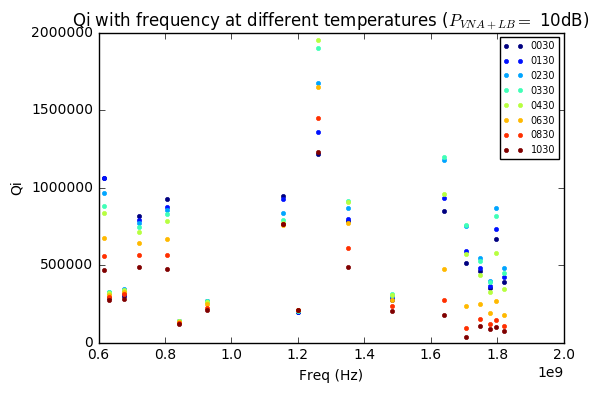

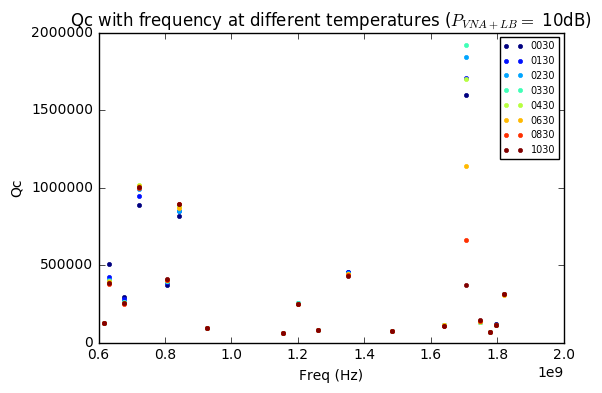

In [7]:
colors = plt.cm.jet(np.linspace(0,1,len(Tset)))
for t in range (len(Tset)):
    plt.plot(f0set[t,1,:],Qiset[t,1,:],'.', color=colors[t], label=Tset[t])
plt.legend(loc='best',fontsize='x-small')
plt.xlabel('Freq (Hz)')
plt.ylabel('Qi')
plt.title('Qi with frequency at different temperatures ($P_{VNA + LB} =$ 10dB)')
plt.figure()
for t in range (len(Tset)):
    plt.plot(f0set[t,1,:],Qcset[t,1,:],'.', color=colors[t], label=Tset[t])
plt.legend(loc='best',fontsize='x-small')
plt.xlabel('Freq (Hz)')
plt.ylabel('Qc')
plt.title('Qc with frequency at different temperatures ($P_{VNA + LB} =$ 10dB)')

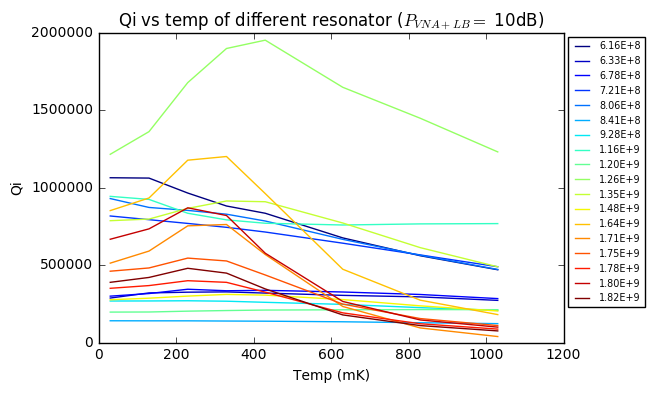

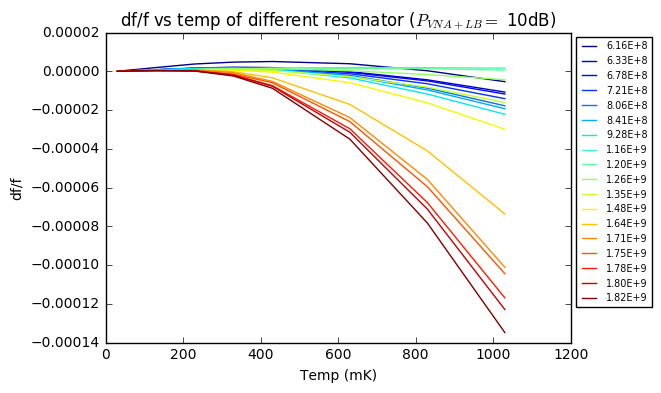

In [8]:
colors = plt.cm.jet(np.linspace(0,1,nres))
temp = np.asarray([30,130,230,330,430,630,830,1030])
for r in range(nres):
    plt.plot(temp,Qiset[:,1,r],'-', color=colors[r], label="{:.2E}".format(Decimal(f0set[0,1,r])))
plt.legend(loc='best',fontsize='x-small',bbox_to_anchor=(1, 1))
plt.xlabel('Temp (mK)')
plt.ylabel('Qi')
plt.title('Qi vs temp of different resonator ($P_{VNA + LB} =$ 10dB)')
plt.figure()
for r in range(nres):
    plt.plot(temp,(f0set[:,1,r]-f0set[0,1,r])/f0set[0,1,r],'-', color=colors[r], label="{:.2E}".format(Decimal(f0set[0,1,r])))
plt.legend(loc='best',fontsize='x-small',bbox_to_anchor=(1, 1))
plt.ylabel('df/f')
plt.xlabel('Temp (mK)')
plt.title('df/f vs temp of different resonator ($P_{VNA + LB} =$ 10dB)')


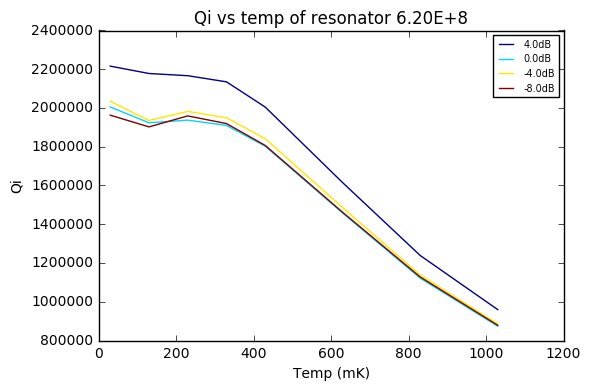

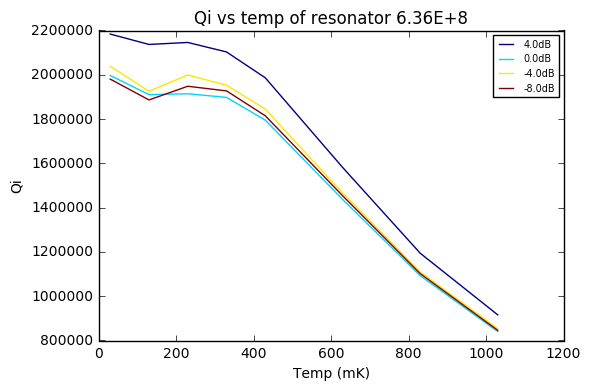

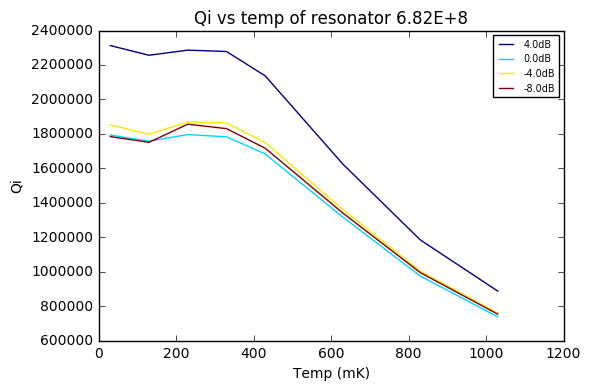

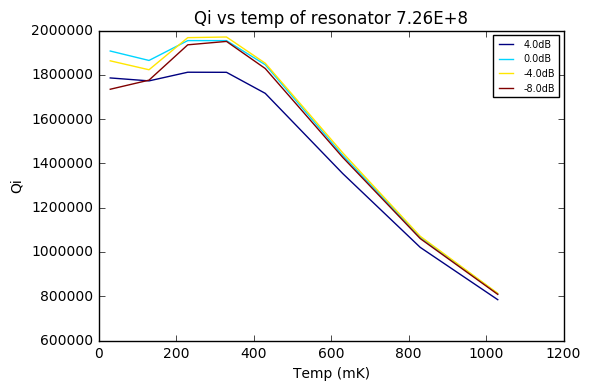

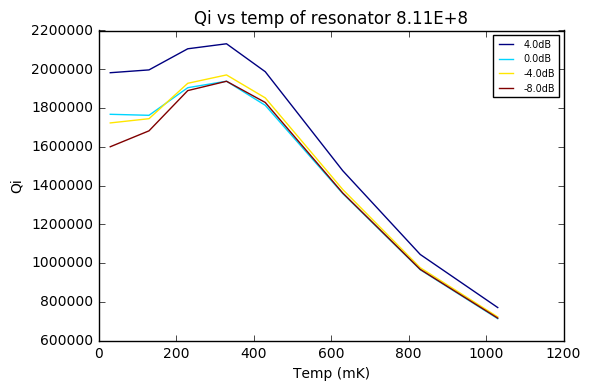

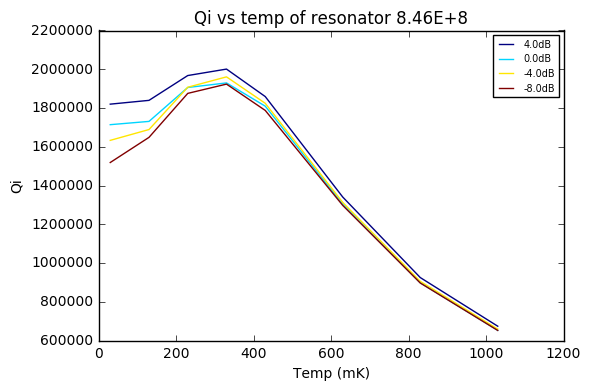

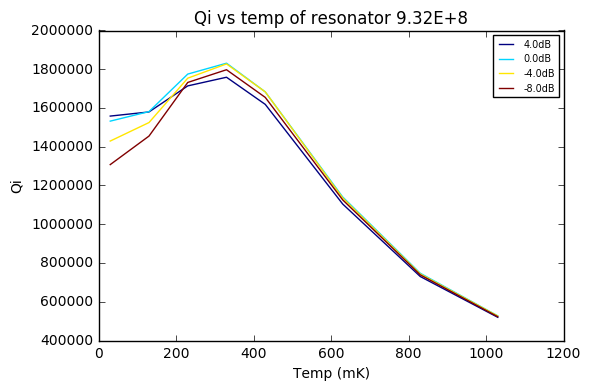

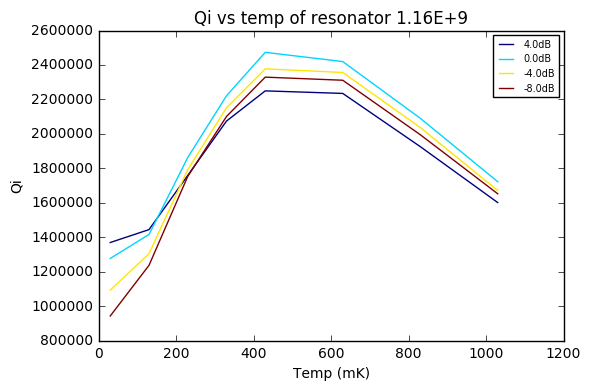

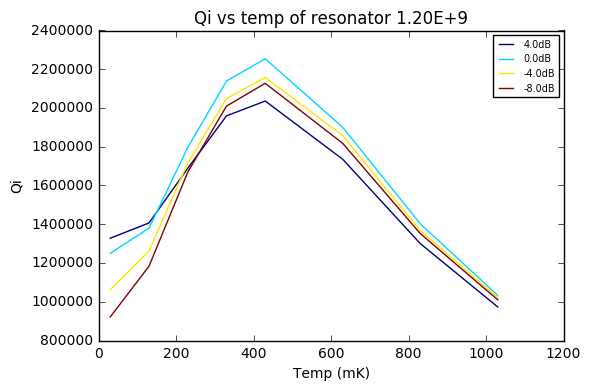

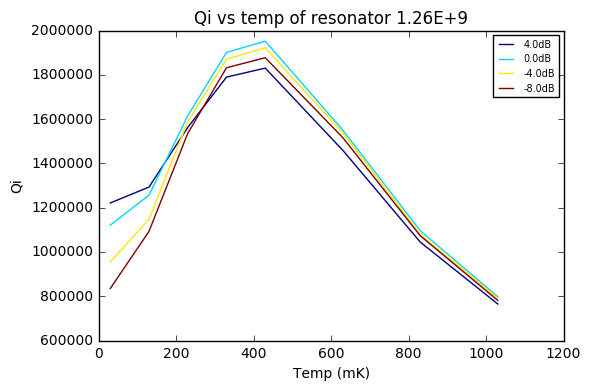

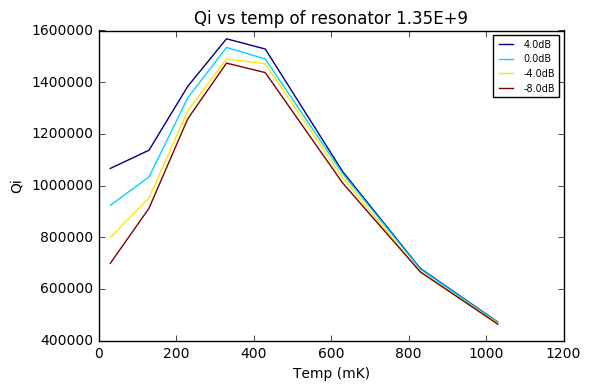

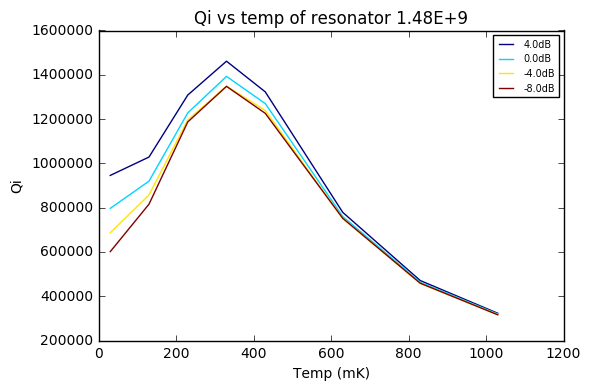

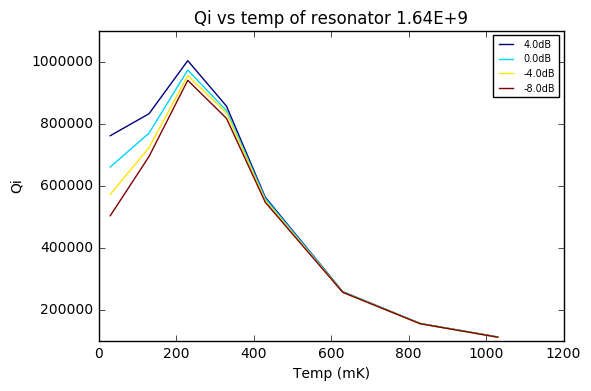

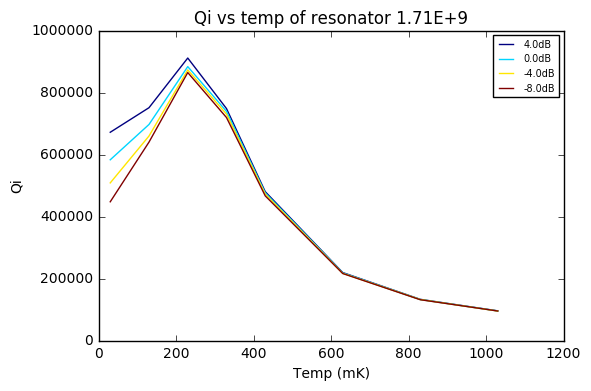

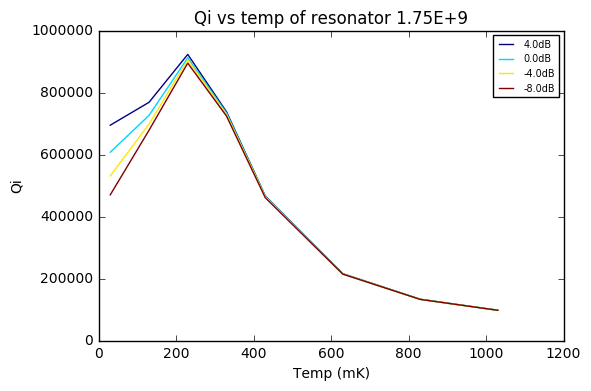

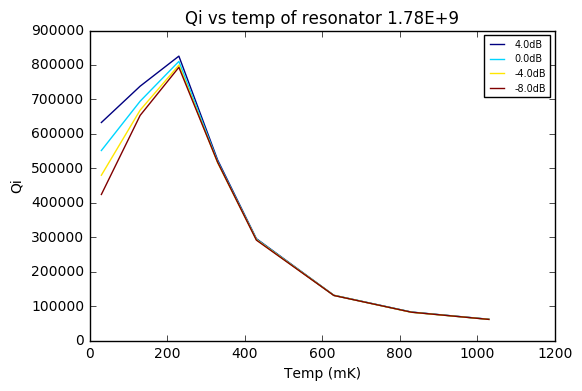

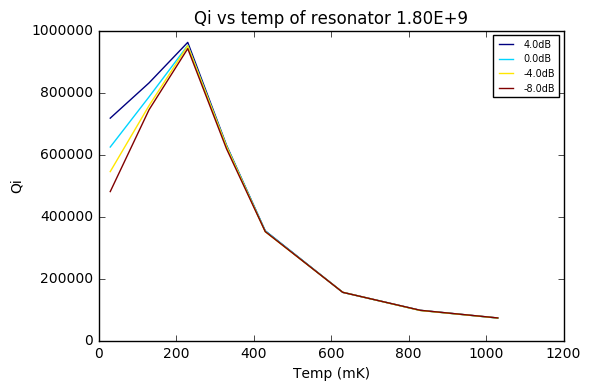

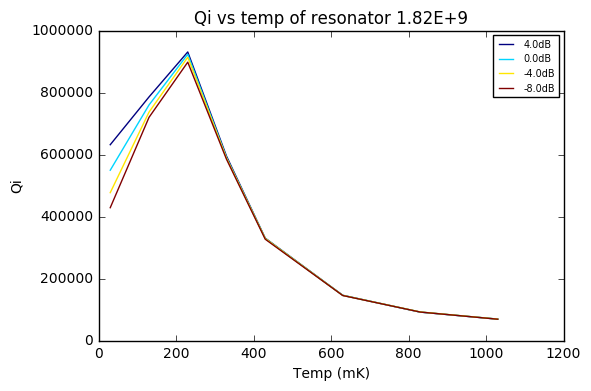

In [31]:
colors = plt.cm.jet(np.linspace(0,1, len(Pset)))
temp = np.asarray([30,130,230,330,430,630,830,1030])
for r in range(nres):
    plt.figure()
    for p in range(len(Pset)):
        plt.plot(temp,Qiset[:,p,r],'-', color=colors[p], label=Pset[p] + "dB")
    plt.legend(loc='best',fontsize='x-small',bbox_to_anchor=(1, 1))
    plt.xlabel('Temp (mK)')
    plt.ylabel('Qi')
    plt.title('Qi vs temp of resonator '+"{:.2E}".format(Decimal(f0set[0,0,r])))
    plt.savefig('Res'+str(r)+'_QivsT_for_powers.png')
plt.figure()
# for r in range(nres):
#     plt.plot(temp,(f0set[:,1,r]-f0set[0,1,r])/f0set[0,1,r],'-', color=colors[r], label="{:.2E}".format(Decimal(f0set[0,1,r])))
# plt.legend(loc='best',fontsize='x-small',bbox_to_anchor=(1, 1))
# plt.ylabel('df/f')
# plt.xlabel('Temp (mK)')
# plt.title('df/f vs temp of different resonator ($P_{VNA + LB} =$ 10dB)')

In [48]:
np.ones(5, dtype = int)

array([1, 1, 1, 1, 1])